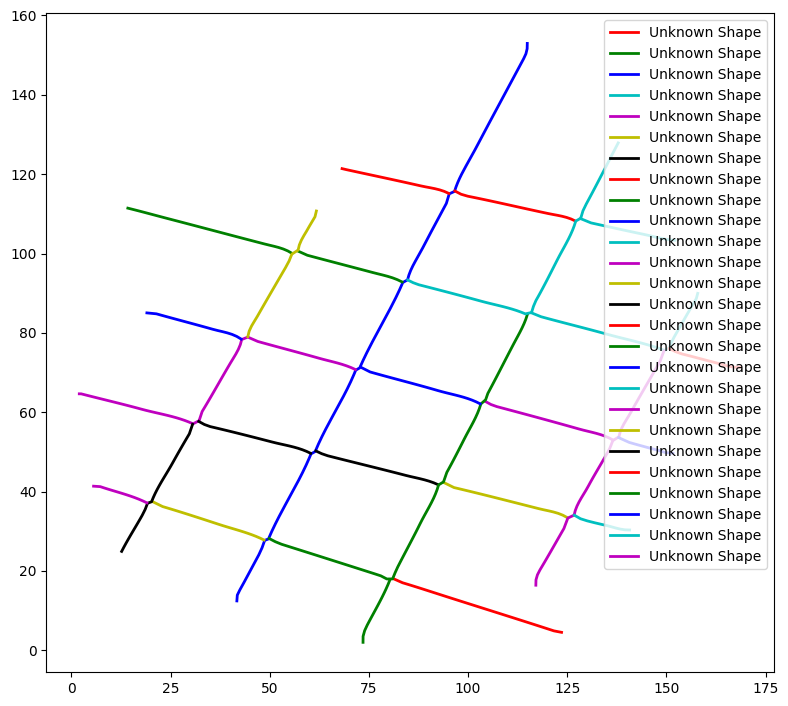

No symmetry found.


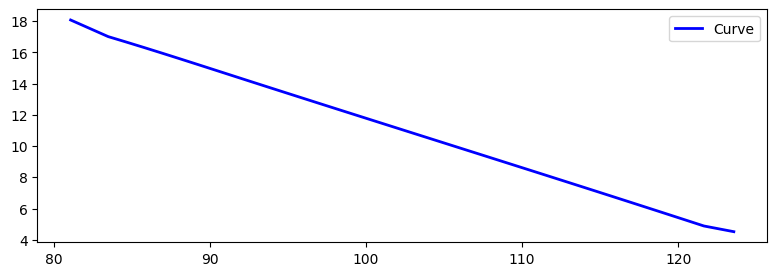

No symmetry found.


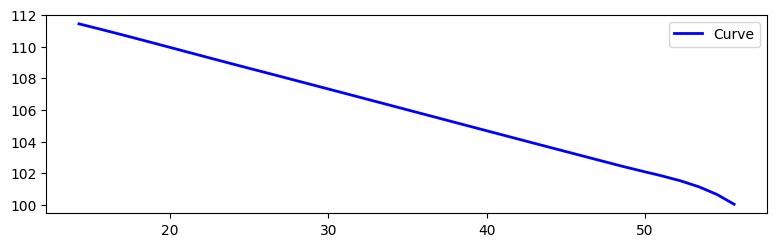

No symmetry found.


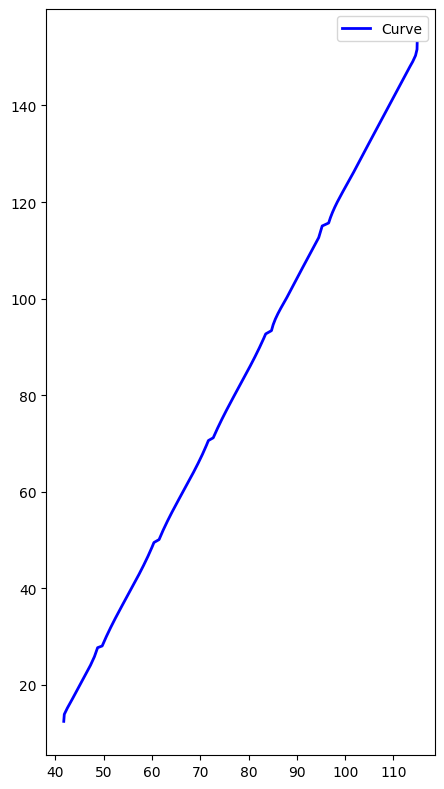

No symmetry found.


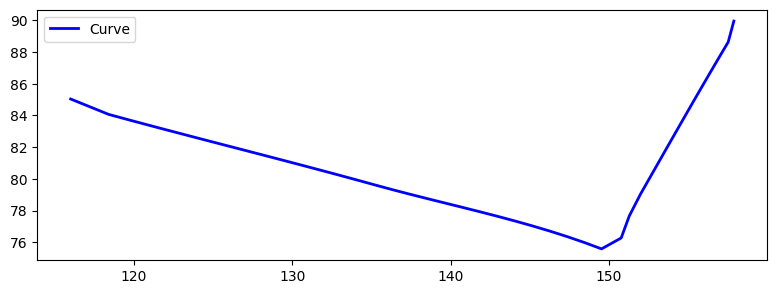

No symmetry found.


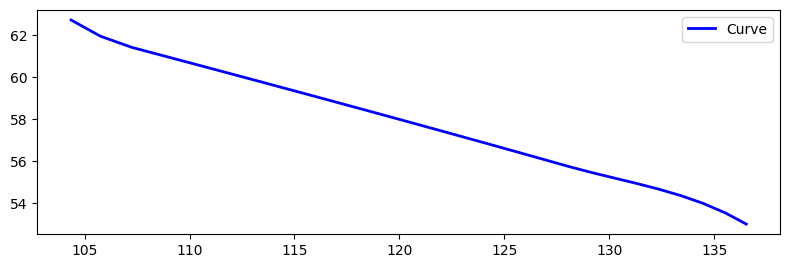

No symmetry found.


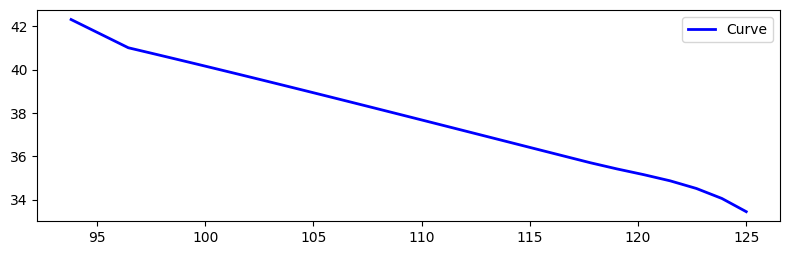

No symmetry found.


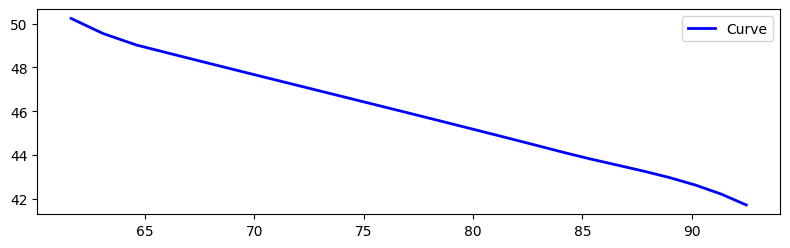

No symmetry found.


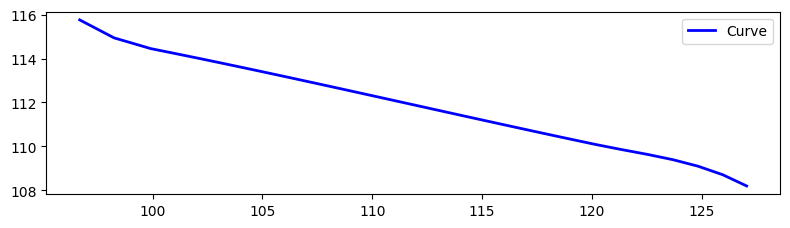

No symmetry found.


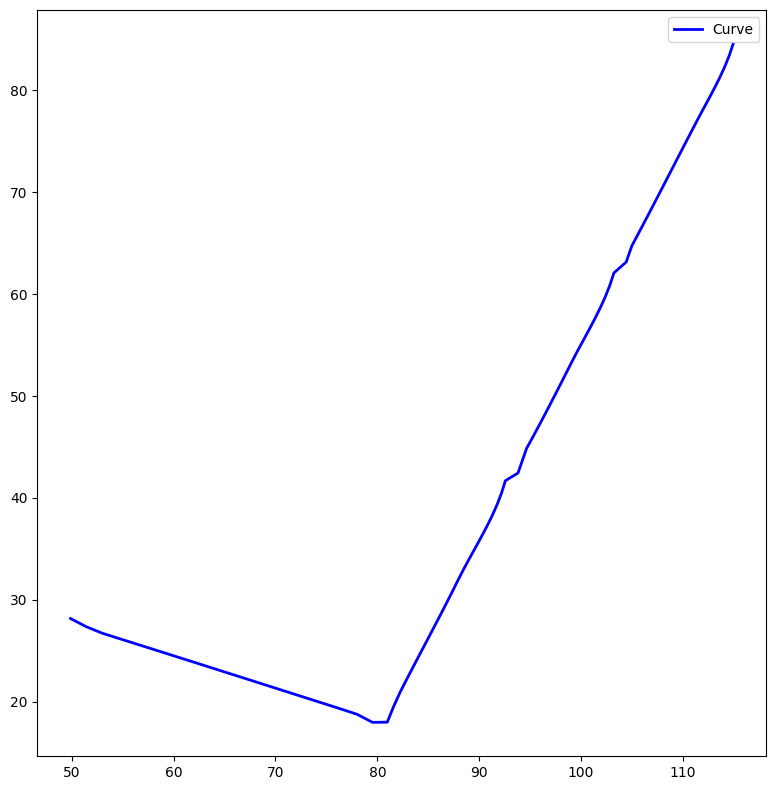

No symmetry found.


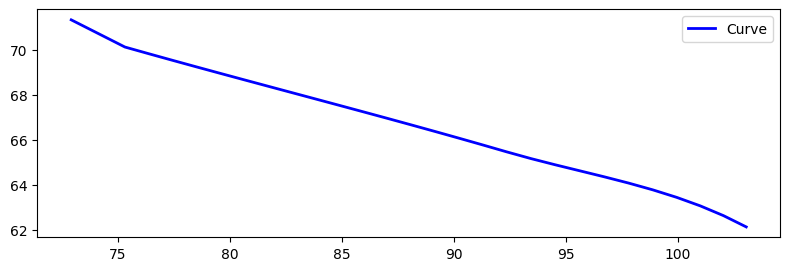

No symmetry found.


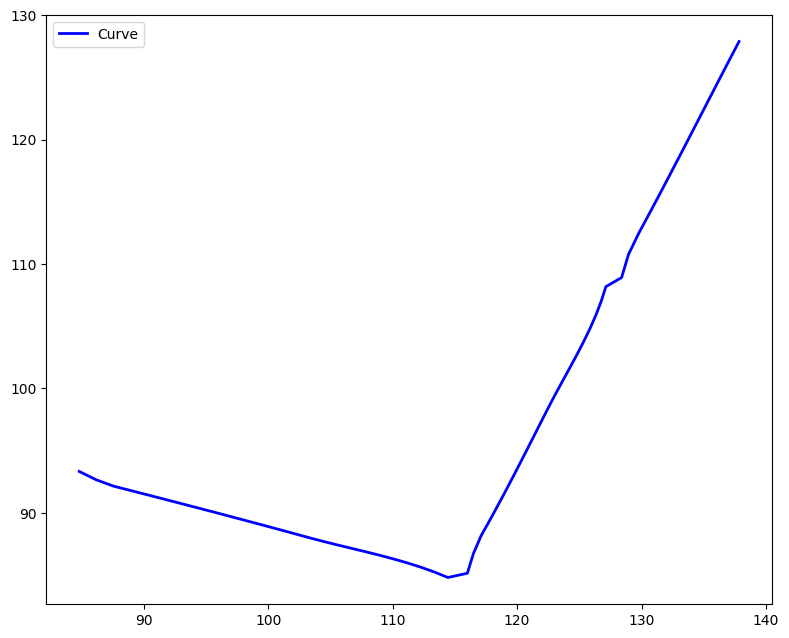

No symmetry found.


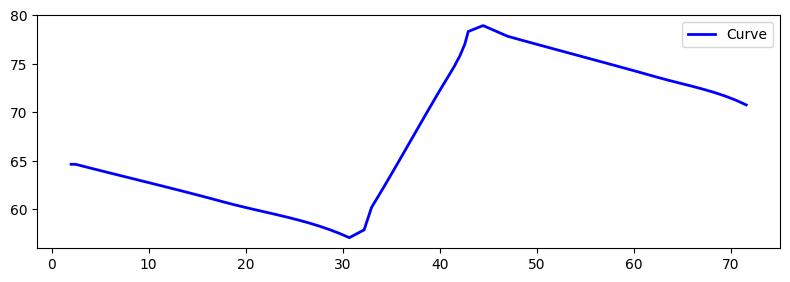

No symmetry found.


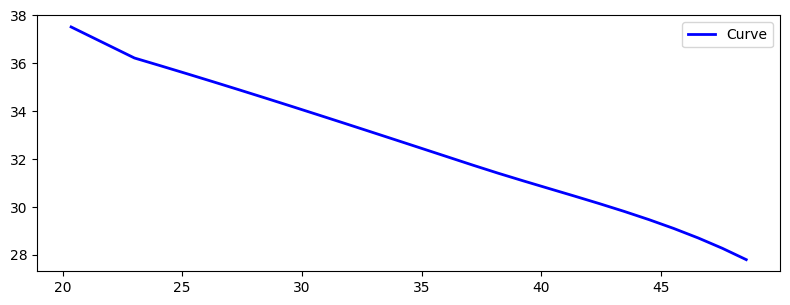

No symmetry found.


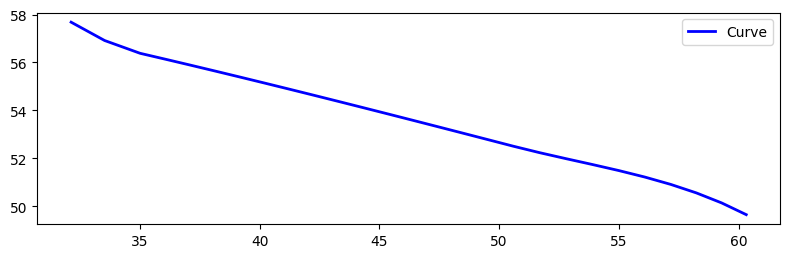

No symmetry found.


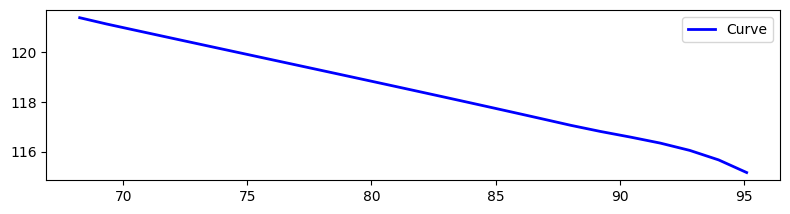

No symmetry found.


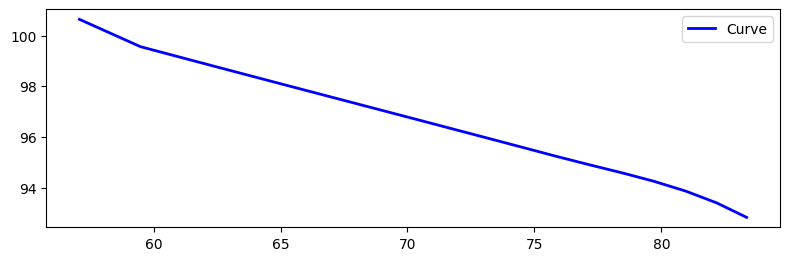

No symmetry found.


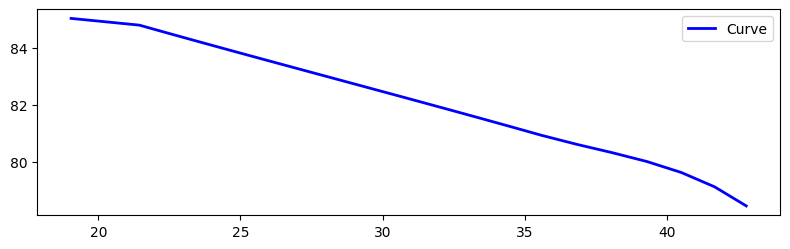

No symmetry found.


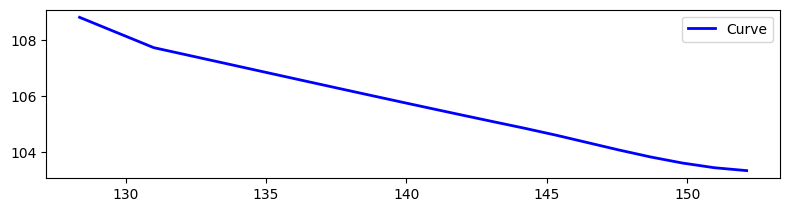

No symmetry found.


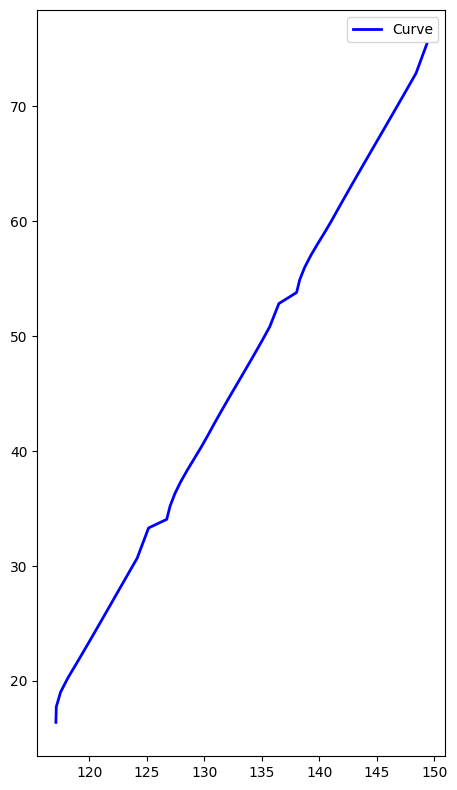

No symmetry found.


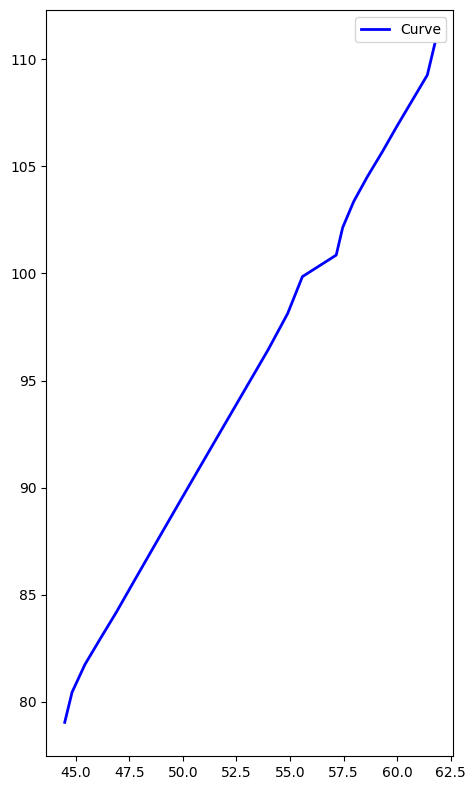

No symmetry found.


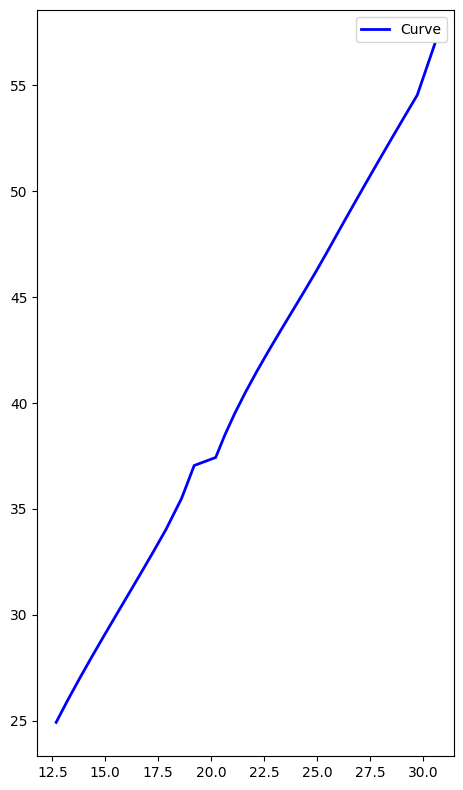

No symmetry found.


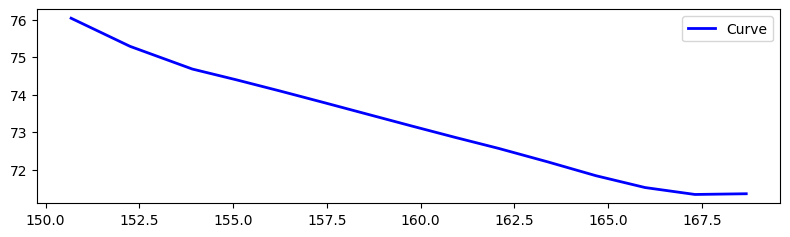

No symmetry found.


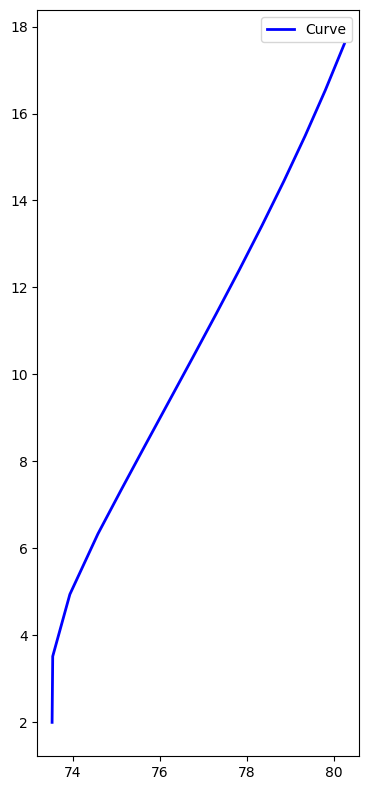

No symmetry found.


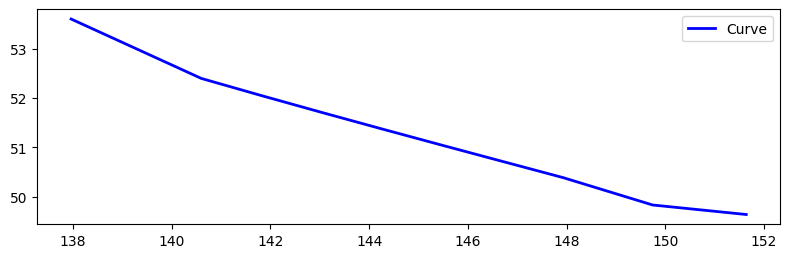

No symmetry found.


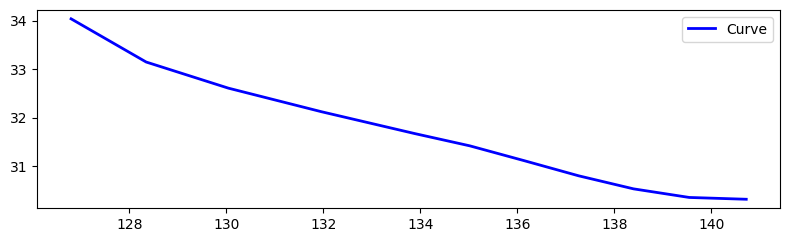

No symmetry found.


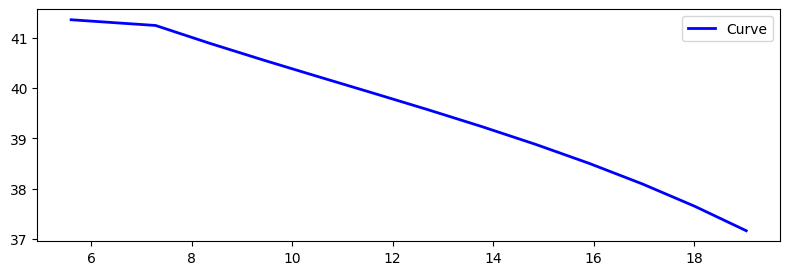

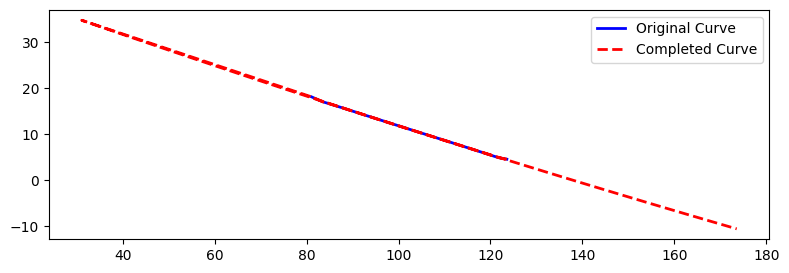

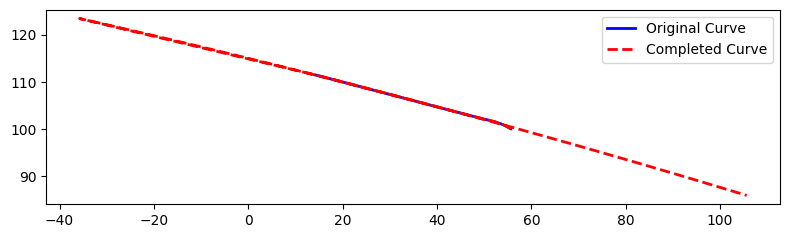

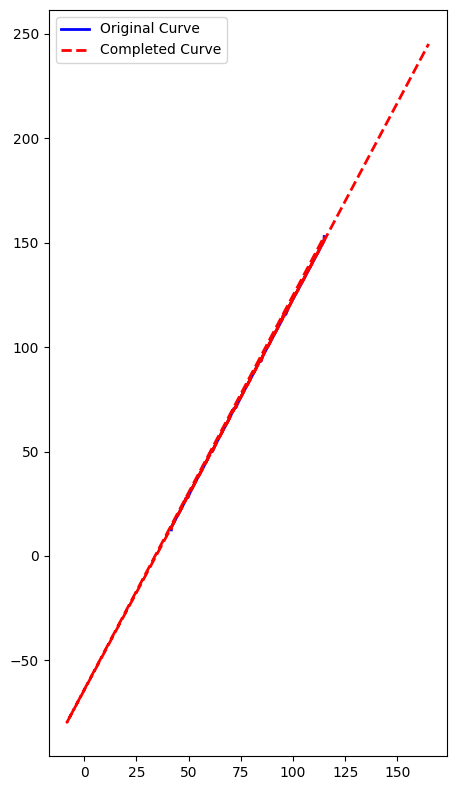

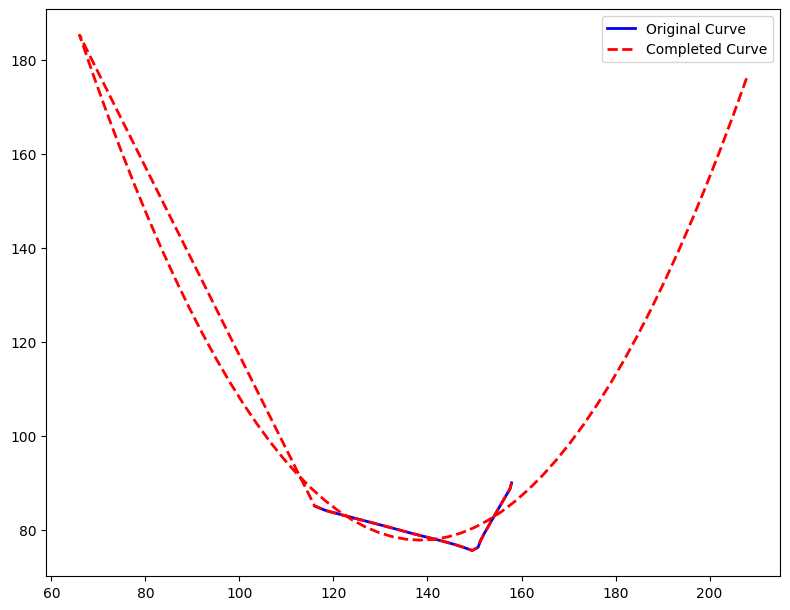

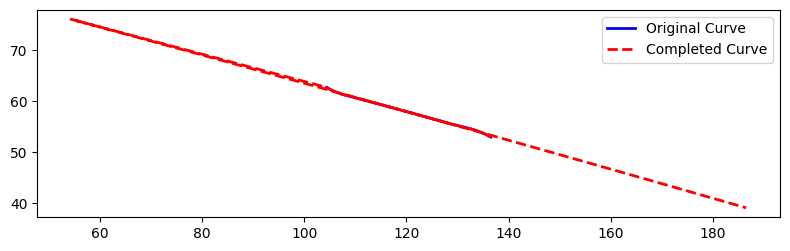

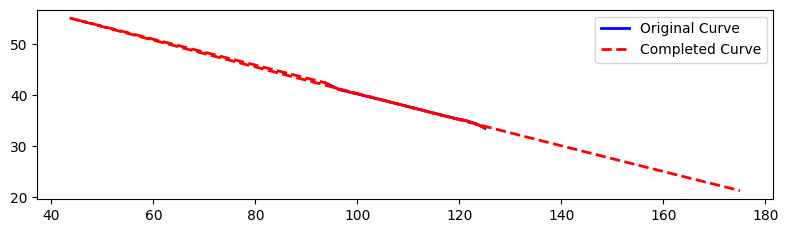

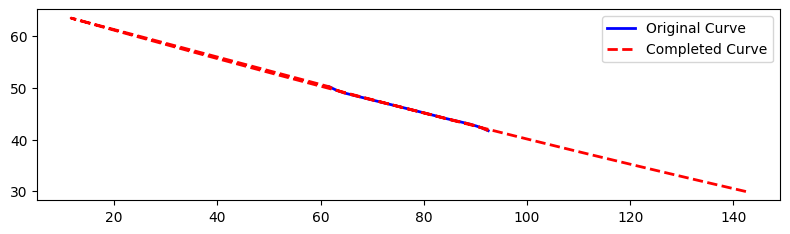

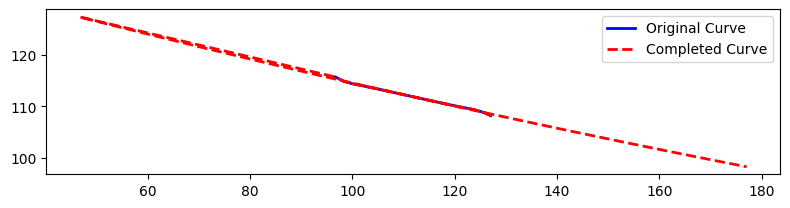

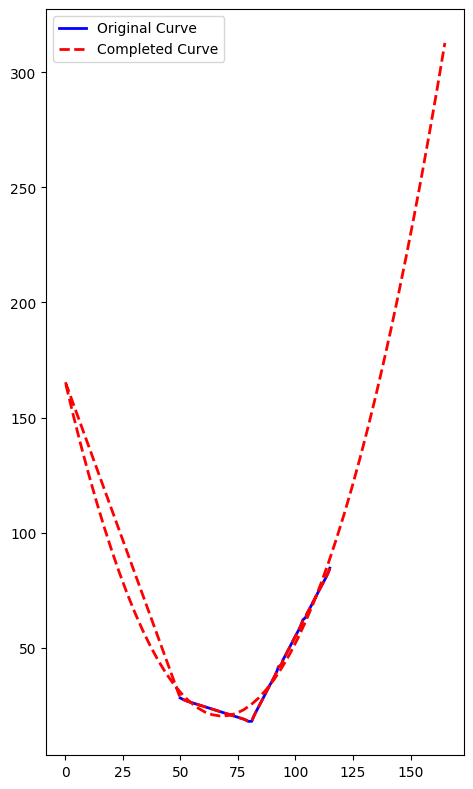

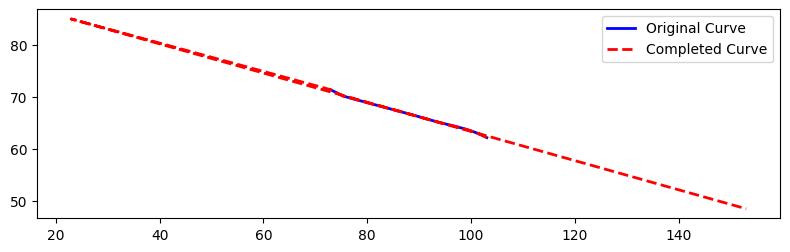

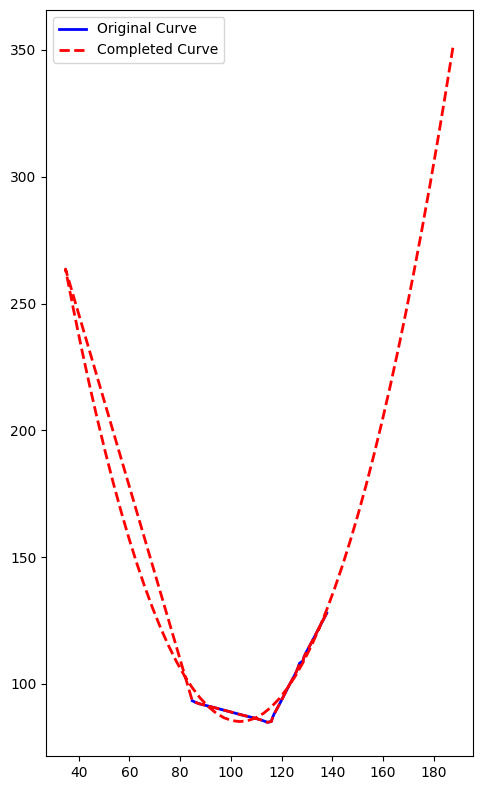

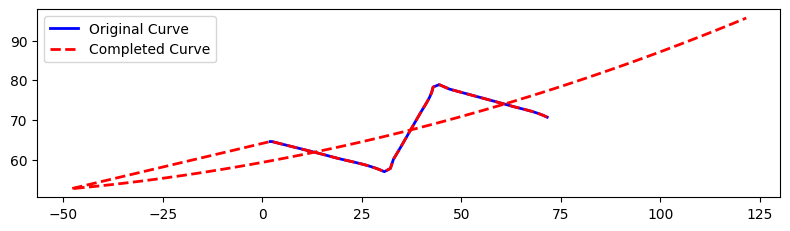

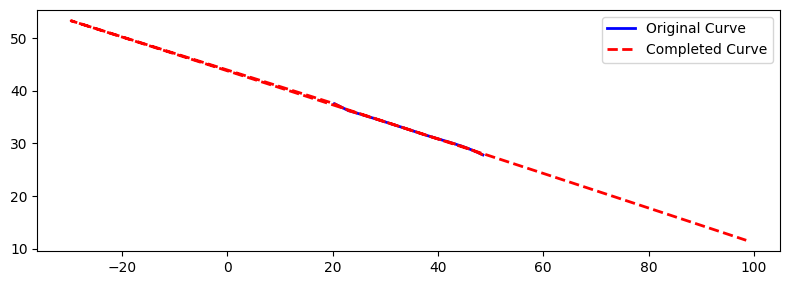

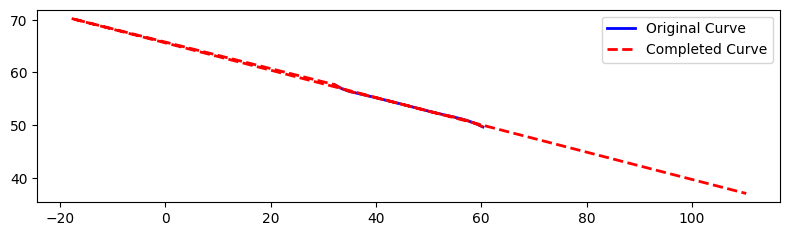

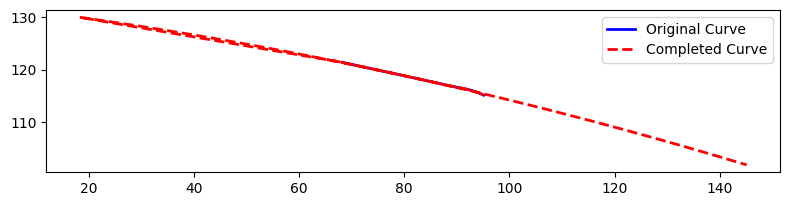

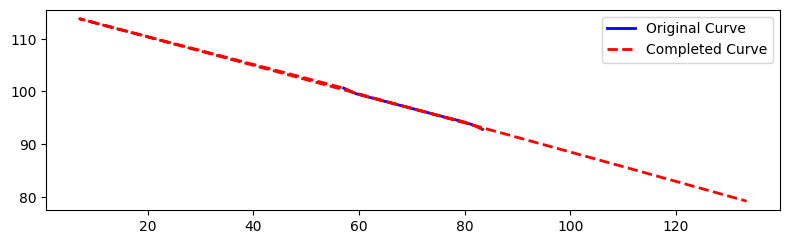

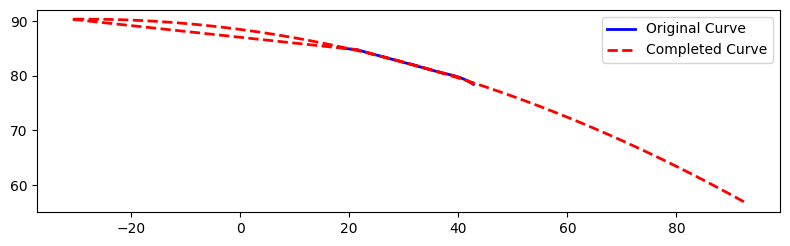

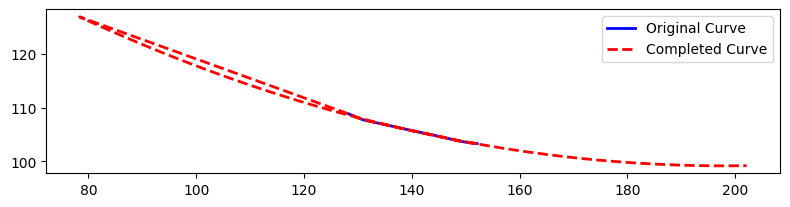

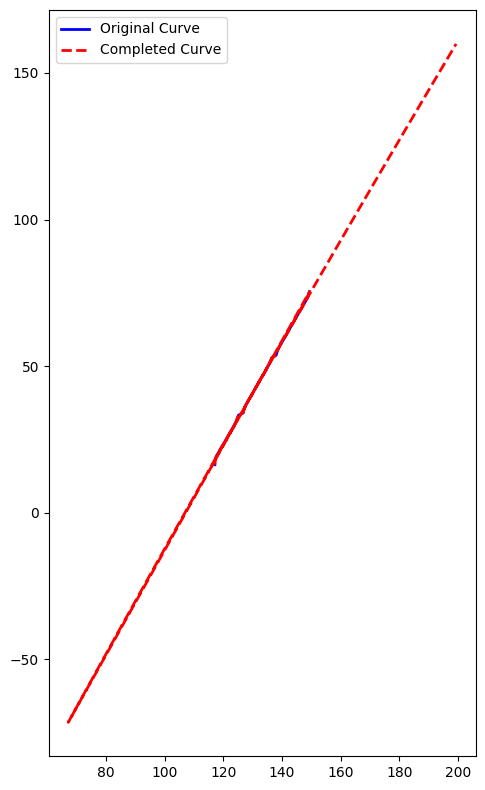

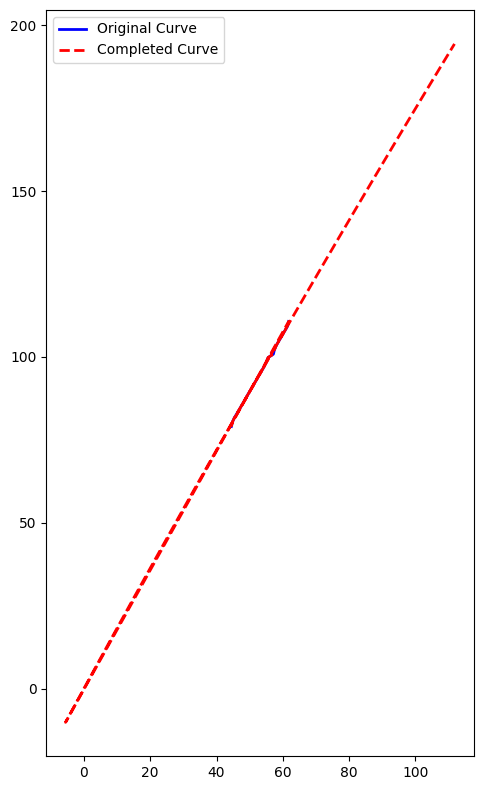

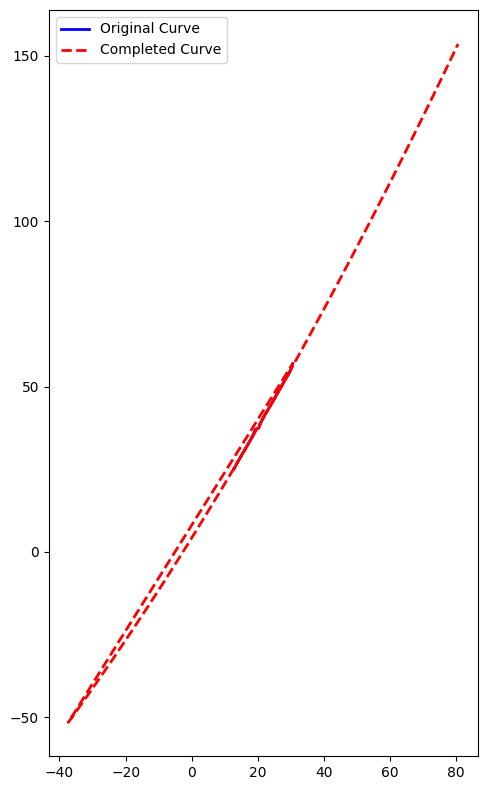

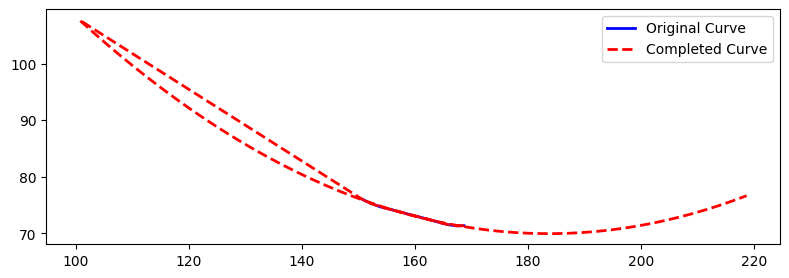

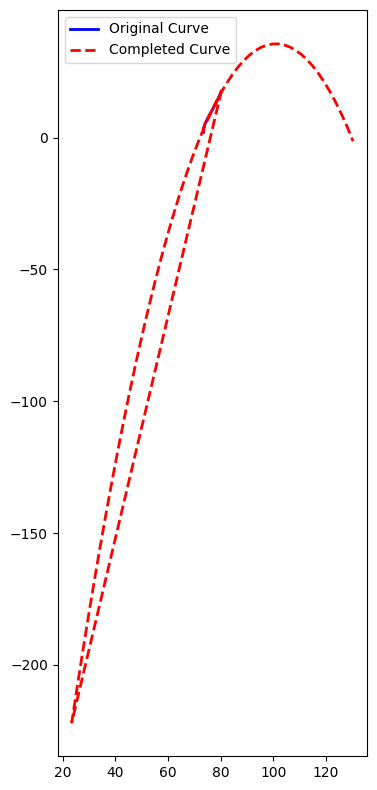

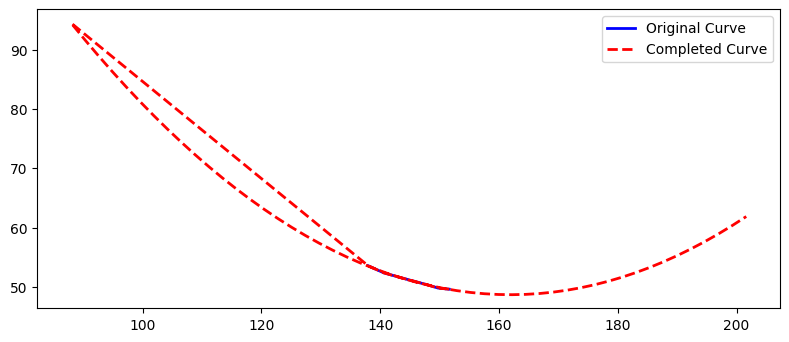

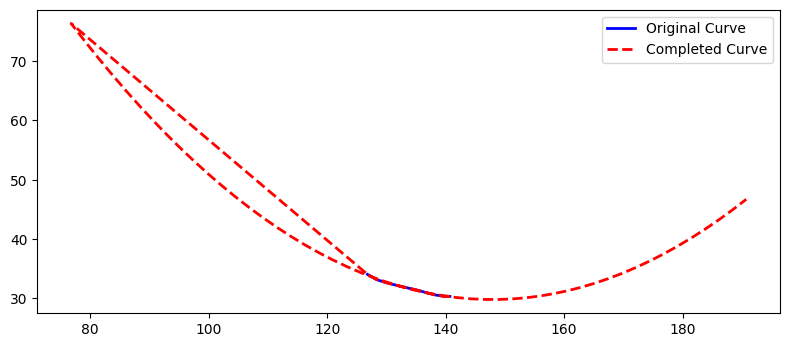

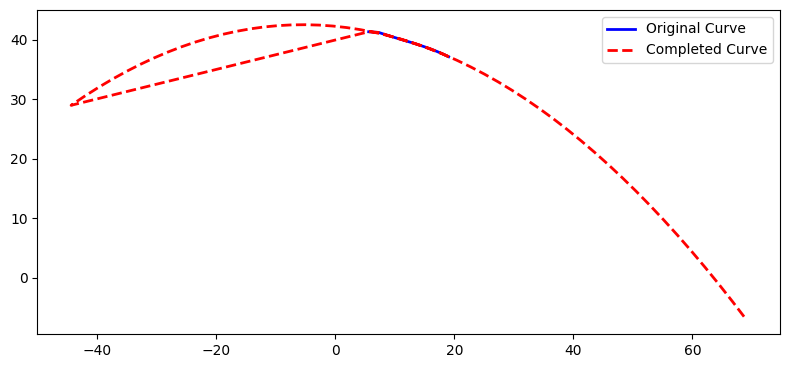

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# Read the CSV file function
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

# Regularization Functions

def is_straight_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    return np.allclose(y, y_pred)

def is_circle(points):
    X = points[:, 0]
    Y = points[:, 1]
    Xc = np.mean(X)
    Yc = np.mean(Y)
    radius = np.sqrt((X - Xc)**2 + (Y - Yc)**2)
    return np.allclose(radius, np.mean(radius))

def is_ellipse(points):
    X = points[:, 0]
    Y = points[:, 1]
    Xc = np.mean(X)
    Yc = np.mean(Y)
    a = np.max(X) - np.min(X)
    b = np.max(Y) - np.min(Y)
    return np.allclose(((X - Xc)**2) / (a**2) + ((Y - Yc)**2) / (b**2), 1)

def classify_shapes(paths_XYs):
    labels = []
    for XYs in paths_XYs:
        for XY in XYs:
            if is_straight_line(XY):
                labels.append('Straight Line')
            elif is_circle(XY):
                labels.append('Circle')
            elif is_ellipse(XY):
                labels.append('Ellipse')
            else:
                labels.append('Unknown Shape')
    return labels

# Symmetry Exploration Functions

def check_reflection_symmetry(XY, angle=0):
    R = np.array([[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle), np.cos(-angle)]])
    rotated_XY = XY @ R.T
    reflected_XY = np.copy(rotated_XY)
    reflected_XY[:, 0] = -reflected_XY[:, 0]
    distances = cdist(rotated_XY, reflected_XY)
    min_distances = np.min(distances, axis=1)
    return np.all(min_distances < 1e-3)

def find_best_symmetry(XY):
    best_angle = None
    best_symmetry = False
    for angle in np.linspace(0, np.pi, 180):
        if check_reflection_symmetry(XY, angle):
            best_angle = angle
            best_symmetry = True
            break
    return np.degrees(best_angle) if best_angle is not None else None, best_symmetry

# Curve Completion Functions

def fit_polynomial(XY, degree=2):
    X = XY[:, 0]
    Y = XY[:, 1]
    coeffs = np.polyfit(X, Y, degree)
    poly = np.poly1d(coeffs)
    return poly

def complete_curve(XY, extension_length=50, degree=2):
    poly = fit_polynomial(XY, degree)
    X_min, X_max = np.min(XY[:, 0]), np.max(XY[:, 0])
    X_extension = np.linspace(X_min - extension_length, X_max + extension_length, extension_length)
    Y_extension = poly(X_extension)
    extended_XY = np.column_stack((X_extension, Y_extension))
    return np.vstack((XY, extended_XY))

# Visualization Functions

def plot_shapes(paths_XYs, labels):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for i, (XYs, label) in enumerate(zip(paths_XYs, labels)):
        c = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, label=label)
    ax.set_aspect('equal')
    plt.legend()
    plt.show()

def plot_symmetry(XY, angle, is_symmetric):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    ax.plot(XY[:, 0], XY[:, 1], 'b-', linewidth=2, label='Curve')
    if is_symmetric:
        x = np.linspace(np.min(XY[:, 0]), np.max(XY[:, 0]), 100)
        y = np.tan(angle) * x
        ax.plot(x, y, 'r--', linewidth=2, label=f'Symmetry line at {angle:.2f} degrees')
    ax.set_aspect('equal')
    plt.legend()
    plt.show()

def plot_completed_curve(original_XY, completed_XY):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    ax.plot(original_XY[:, 0], original_XY[:, 1], 'b-', linewidth=2, label='Original Curve')
    ax.plot(completed_XY[:, 0], completed_XY[:, 1], 'r--', linewidth=2, label='Completed Curve')
    ax.set_aspect('equal')
    plt.legend()
    plt.show()

# Combined Main Function

def main(csv_path):
    paths_XYs = read_csv(csv_path)

    # Step 1: Regularization
    labels = classify_shapes(paths_XYs)
    plot_shapes(paths_XYs, labels)

    # Step 2: Symmetry Exploration
    for XYs in paths_XYs:
        for XY in XYs:
            angle, is_symmetric = find_best_symmetry(XY)
            if is_symmetric:
                print(f"Symmetric curve found at angle: {angle:.2f} degrees")
            else:
                print("No symmetry found.")
            plot_symmetry(XY, np.radians(angle) if angle else 0, is_symmetric)

    # Step 3: Curve Completion
    for XYs in paths_XYs:
        for XY in XYs:
            completed_XY = complete_curve(XY)
            plot_completed_curve(XY, completed_XY)

# Load the CSV file and process the curves
csv_path = "/content/drive/MyDrive/Adobe (geeksforgeeks)/frag2.csv"
main(csv_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.


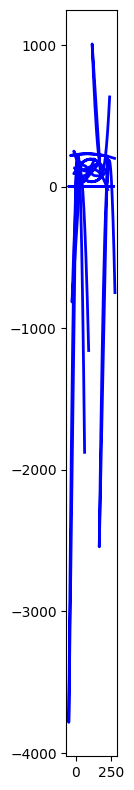

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# Read the CSV file function
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

# Regularization Functions

def is_straight_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    return np.allclose(y, y_pred)

def is_circle(points):
    X = points[:, 0]
    Y = points[:, 1]
    Xc = np.mean(X)
    Yc = np.mean(Y)
    radius = np.sqrt((X - Xc)**2 + (Y - Yc)**2)
    return np.allclose(radius, np.mean(radius))

def is_ellipse(points):
    X = points[:, 0]
    Y = points[:, 1]
    Xc = np.mean(X)
    Yc = np.mean(Y)
    a = np.max(X) - np.min(X)
    b = np.max(Y) - np.min(Y)
    return np.allclose(((X - Xc)**2) / (a**2) + ((Y - Yc)**2) / (b**2), 1)

def classify_shapes(paths_XYs):
    labels = []
    for XYs in paths_XYs:
        for XY in XYs:
            if is_straight_line(XY):
                labels.append('Straight Line')
            elif is_circle(XY):
                labels.append('Circle')
            elif is_ellipse(XY):
                labels.append('Ellipse')
            else:
                labels.append('Unknown Shape')
    return labels

# Symmetry Exploration Functions

def check_reflection_symmetry(XY, angle=0):
    R = np.array([[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle), np.cos(-angle)]])
    rotated_XY = XY @ R.T
    reflected_XY = np.copy(rotated_XY)
    reflected_XY[:, 0] = -reflected_XY[:, 0]
    distances = cdist(rotated_XY, reflected_XY)
    min_distances = np.min(distances, axis=1)
    return np.all(min_distances < 1e-3)

def find_best_symmetry(XY):
    best_angle = None
    best_symmetry = False
    for angle in np.linspace(0, np.pi, 180):
        if check_reflection_symmetry(XY, angle):
            best_angle = angle
            best_symmetry = True
            break
    return np.degrees(best_angle) if best_angle is not None else None, best_symmetry

# Curve Completion Functions

def fit_polynomial(XY, degree=2):
    X = XY[:, 0]
    Y = XY[:, 1]
    coeffs = np.polyfit(X, Y, degree)
    poly = np.poly1d(coeffs)
    return poly

def complete_curve(XY, extension_length=50, degree=2):
    poly = fit_polynomial(XY, degree)
    X_min, X_max = np.min(XY[:, 0]), np.max(XY[:, 0])
    X_extension = np.linspace(X_min - extension_length, X_max + extension_length, extension_length)
    Y_extension = poly(X_extension)
    extended_XY = np.column_stack((X_extension, Y_extension))
    return np.vstack((XY, extended_XY))

# Visualization Functions

def plot_final_combined_curve(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for XYs in paths_XYs:
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], 'b-', linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Combined Main Function

def main(csv_path):
    paths_XYs = read_csv(csv_path)

    # Step 1: Regularization
    labels = classify_shapes(paths_XYs)

    # Step 2: Symmetry Exploration
    for XYs in paths_XYs:
        for XY in XYs:
            angle, is_symmetric = find_best_symmetry(XY)
            if is_symmetric:
                print(f"Symmetric curve found at angle: {angle:.2f} degrees")
            else:
                print("No symmetry found.")

    # Step 3: Curve Completion
    completed_curves = []
    for XYs in paths_XYs:
        completed_XYs = []
        for XY in XYs:
            completed_XY = complete_curve(XY)
            completed_XYs.append(completed_XY)
        completed_curves.append(completed_XYs)

    # Plot final combined curves
    plot_final_combined_curve(completed_curves)

# Load the CSV file and process the curves
csv_path = "/content/drive/MyDrive/Adobe (geeksforgeeks)/frag0.csv"
main(csv_path)


No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.


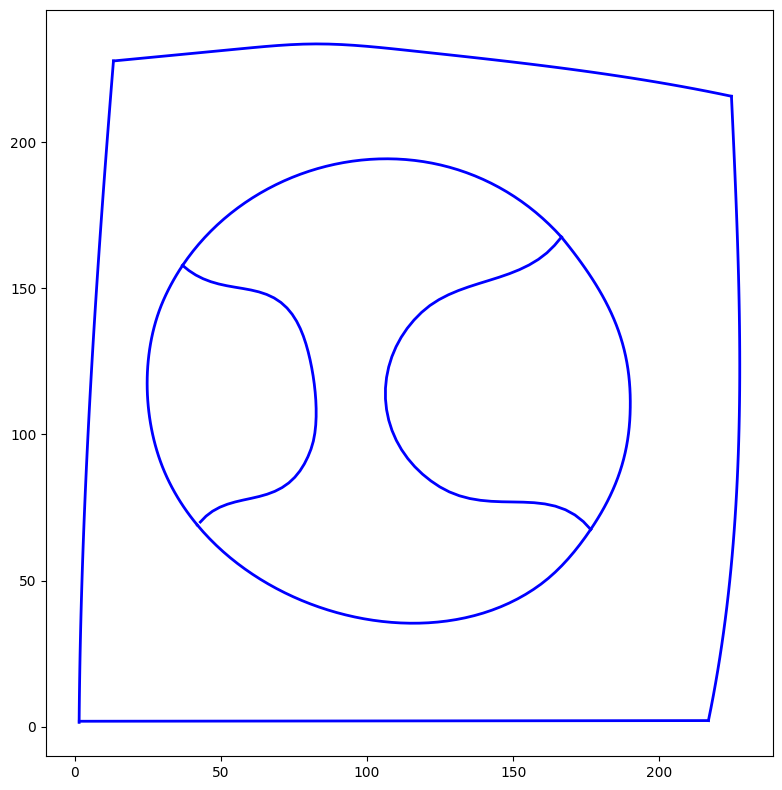

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d, splprep, splev

# Read the CSV file function
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

# Regularization Functions

def is_straight_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    return np.allclose(y, y_pred)

def is_circle(points):
    X = points[:, 0]
    Y = points[:, 1]
    Xc = np.mean(X)
    Yc = np.mean(Y)
    radius = np.sqrt((X - Xc)**2 + (Y - Yc)**2)
    return np.allclose(radius, np.mean(radius))

def is_ellipse(points):
    X = points[:, 0]
    Y = points[:, 1]
    Xc = np.mean(X)
    Yc = np.mean(Y)
    a = np.max(X) - np.min(X)
    b = np.max(Y) - np.min(Y)
    return np.allclose(((X - Xc)**2) / (a**2) + ((Y - Yc)**2) / (b**2), 1)

def classify_shapes(paths_XYs):
    labels = []
    for XYs in paths_XYs:
        for XY in XYs:
            if is_straight_line(XY):
                labels.append('Straight Line')
            elif is_circle(XY):
                labels.append('Circle')
            elif is_ellipse(XY):
                labels.append('Ellipse')
            else:
                labels.append('Unknown Shape')
    return labels

# Symmetry Exploration Functions

def check_reflection_symmetry(XY, angle=0):
    R = np.array([[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle), np.cos(-angle)]])
    rotated_XY = XY @ R.T
    reflected_XY = np.copy(rotated_XY)
    reflected_XY[:, 0] = -reflected_XY[:, 0]
    distances = cdist(rotated_XY, reflected_XY)
    min_distances = np.min(distances, axis=1)
    return np.all(min_distances < 1e-3)

def find_best_symmetry(XY):
    best_angle = None
    best_symmetry = False
    for angle in np.linspace(0, np.pi, 180):
        if check_reflection_symmetry(XY, angle):
            best_angle = angle
            best_symmetry = True
            break
    return np.degrees(best_angle) if best_angle is not None else None, best_symmetry

# Improved Curve Completion using Spline Interpolation

def complete_curve(XY, extension_length=50):
    tck, u = splprep([XY[:, 0], XY[:, 1]], s=0)
    unew = np.linspace(0, 1, extension_length)
    out = splev(unew, tck)
    completed_XY = np.column_stack(out)
    return completed_XY

# Visualization Functions

def plot_final_combined_curve(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for XYs in paths_XYs:
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], 'b-', linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Combined Main Function

def main(csv_path):
    paths_XYs = read_csv(csv_path)

    # Step 1: Regularization
    labels = classify_shapes(paths_XYs)

    # Step 2: Symmetry Exploration
    for XYs in paths_XYs:
        for XY in XYs:
            angle, is_symmetric = find_best_symmetry(XY)
            if is_symmetric:
                print(f"Symmetric curve found at angle: {angle:.2f} degrees")
            else:
                print("No symmetry found.")

    # Step 3: Curve Completion
    completed_curves = []
    for XYs in paths_XYs:
        completed_XYs = []
        for XY in XYs:
            completed_XY = complete_curve(XY)
            completed_XYs.append(completed_XY)
        completed_curves.append(completed_XYs)

    # Plot final combined curves
    plot_final_combined_curve(completed_curves)

# Load the CSV file and process the curves
csv_path = "/content/drive/MyDrive/Adobe (geeksforgeeks)/frag0.csv"
main(csv_path)


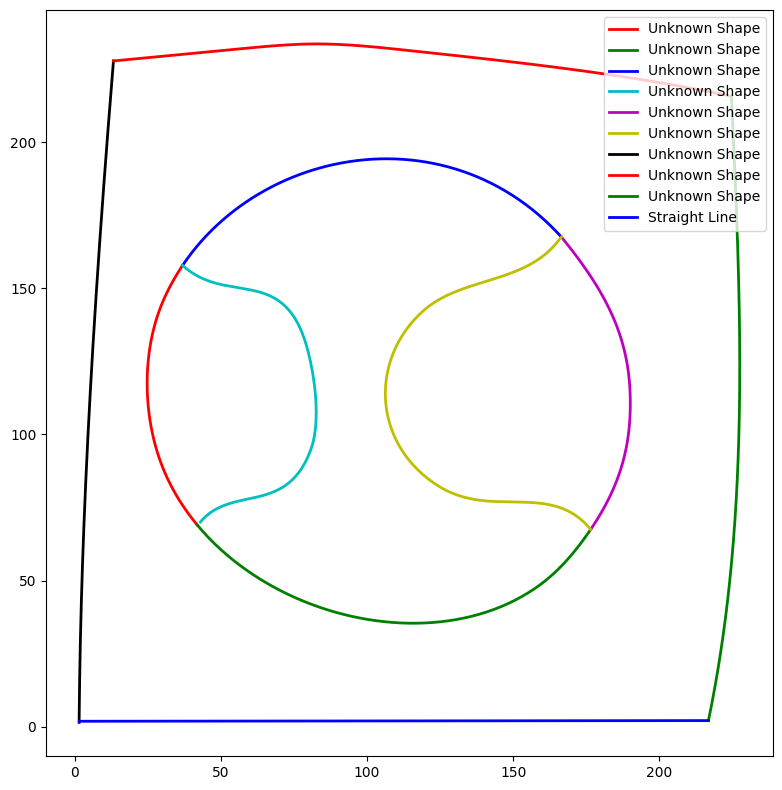

No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.
No symmetry found.


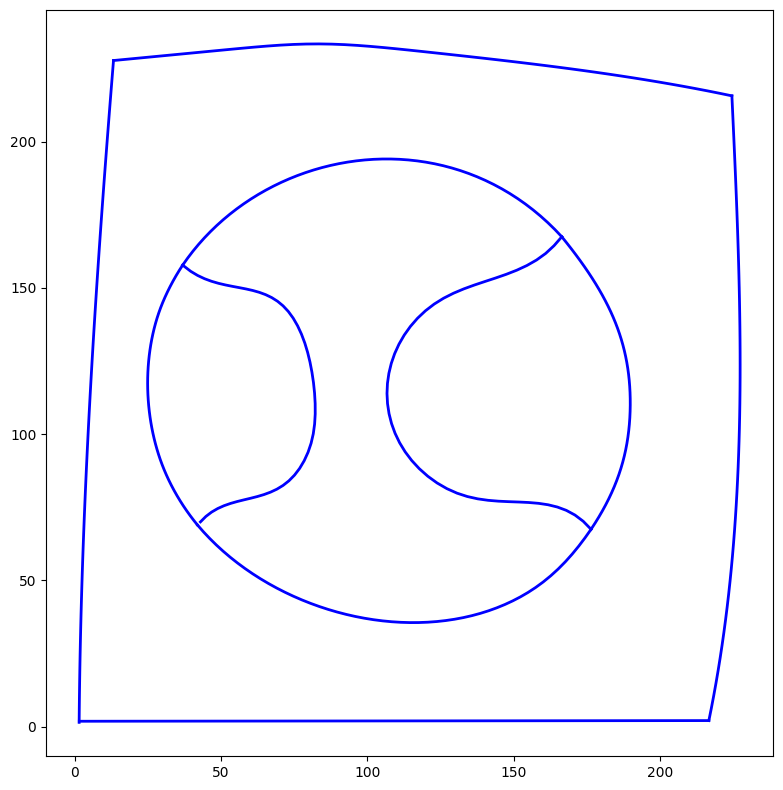

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
from scipy.special import comb

# Read the CSV file function
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

# Regularization Functions

def is_straight_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    return np.allclose(y, y_pred)

def is_circle(points):
    X = points[:, 0]
    Y = points[:, 1]
    Xc = np.mean(X)
    Yc = np.mean(Y)
    radius = np.sqrt((X - Xc)**2 + (Y - Yc)**2)
    return np.allclose(radius, np.mean(radius))

def is_ellipse(points):
    X = points[:, 0]
    Y = points[:, 1]
    Xc = np.mean(X)
    Yc = np.mean(Y)
    a = np.max(X) - np.min(X)
    b = np.max(Y) - np.min(Y)
    return np.allclose(((X - Xc)**2) / (a**2) + ((Y - Yc)**2) / (b**2), 1)

def classify_shapes(paths_XYs):
    labels = []
    for XYs in paths_XYs:
        for XY in XYs:
            if is_straight_line(XY):
                labels.append('Straight Line')
            elif is_circle(XY):
                labels.append('Circle')
            elif is_ellipse(XY):
                labels.append('Ellipse')
            else:
                labels.append('Unknown Shape')
    return labels

# Symmetry Exploration Functions

def check_reflection_symmetry(XY, angle=0):
    R = np.array([[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle), np.cos(-angle)]])
    rotated_XY = XY @ R.T
    reflected_XY = np.copy(rotated_XY)
    reflected_XY[:, 0] = -reflected_XY[:, 0]
    distances = cdist(rotated_XY, reflected_XY)
    min_distances = np.min(distances, axis=1)
    return np.all(min_distances < 1e-3)

def find_best_symmetry(XY):
    best_angle = None
    best_symmetry = False
    for angle in np.linspace(0, np.pi, 180):
        if check_reflection_symmetry(XY, angle):
            best_angle = angle
            best_symmetry = True
            break
    return np.degrees(best_angle) if best_angle is not None else None, best_symmetry

# Bézier Curve Completion Functions

def bernstein_poly(i, n, t):
    return comb(n, i) * (t**i) * ((1 - t)**(n - i))

def bezier_curve(points, n_times=1000):
    n_points = len(points)
    x_points = np.array([p[0] for p in points])
    y_points = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, n_times)

    polynomial_array = np.array([bernstein_poly(i, n_points - 1, t) for i in range(n_points)])
    x_vals = np.dot(polynomial_array.T, x_points)
    y_vals = np.dot(polynomial_array.T, y_points)

    return np.column_stack((x_vals, y_vals))

def complete_curve(XY, extension_length=50):
    extended_XY = bezier_curve(XY, n_times=extension_length)
    return extended_XY

# Visualization Functions

def plot_final_combined_curve(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for XYs in paths_XYs:
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], 'b-', linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Combined Main Function
def plot_shapes(paths_XYs, labels):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for i, (XYs, label) in enumerate(zip(paths_XYs, labels)):
        c = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, label=label)
    ax.set_aspect('equal')
    plt.legend()
    plt.show()

def main(csv_path):
    paths_XYs = read_csv(csv_path)

    # Step 1: Regularization
    labels = classify_shapes(paths_XYs)

    # Step 2: Symmetry Exploration
    for XYs in paths_XYs:
        for XY in XYs:
            angle, is_symmetric = find_best_symmetry(XY)
            if is_symmetric:
                print(f"Symmetric curve found at angle: {angle:.2f} degrees")
            else:
                print("No symmetry found.")

    # Step 3: Curve Completion
    completed_curves = []
    for XYs in paths_XYs:
        completed_XYs = []
        for XY in XYs:
            completed_XY = complete_curve(XY)
            completed_XYs.append(completed_XY)
        completed_curves.append(completed_XYs)

    # Plot final combined curves
    plot_final_combined_curve(completed_curves)

# Load the CSV file and process the curves
csv_path = "/content/drive/MyDrive/Adobe (geeksforgeeks)/frag0.csv"
paths_XYs = read_csv(csv_path)

    # Step 1: Regularization
labels = classify_shapes(paths_XYs)
plot_shapes(paths_XYs, labels)
main(csv_path)
